# HOL2184 - lab 50 - Data Virtualization

## Introduction

DV ...

## 1. Collecting the assets in the project

In order to publish assets to the catalog we first have to collect them in this project. We will add 3 connections and 6 tables to the project and all of them will be published to the catalog later. 

We will use connections to the following data sources in this lab:
- Db2 Warehouse on Cloud Pak for Data
- BigSQL
- DV (Data Virtualization)

If you already created connections to one or more of theses data sources in previous labs, you can skip the parts in this lab.

1. Open a new browser tab to add the assets by right-clicking on the project name and choosing "open in new tab". <br>
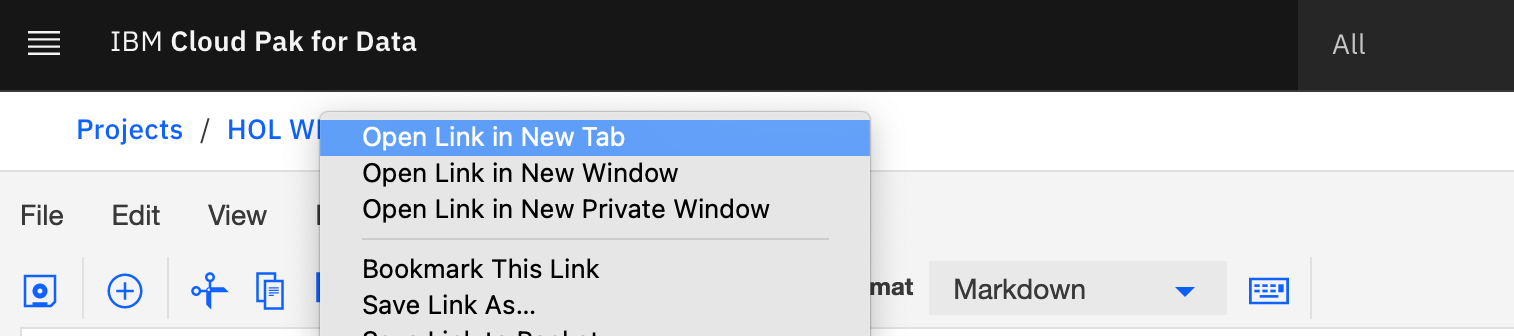

# x. Access DV from SQL

The next part of the lab relies on a Jupyter notebook extension, commonly refer to as a "magic" command, to connect to a Db2 database. To use the commands you load load the extension by running another notebook call db2 that contains all the required code 
<pre>
&#37;run db2.ipynb
</pre>
The cell below loads the Db2 extension directly from GITHUB. Note that it will take a few seconds for the extension to load, so you should generally wait until the "Db2 Extensions Loaded" message is displayed in your notebook. 
1. Click the cell below
2. Click **Run**. When the cell is finished running, In[*] will change to In[2]

In [9]:
# !wget https://raw.githubusercontent.com/IBM/db2-jupyter/master/db2.ipynb
!wget -O db2.ipynb https://raw.githubusercontent.com/Db2-DTE-POC/CPDDVLAB/master/db2.ipynb

%run db2.ipynb
print('db2.ipynb loaded')

--2021-04-30 08:05:45--  https://raw.githubusercontent.com/Db2-DTE-POC/CPDDVLAB/master/db2.ipynb
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153838 (150K) [text/plain]
Saving to: ‘db2.ipynb’

db2.ipynb           100%[===================>] 150.23K  --.-KB/s    in 0.007s  

2021-04-30 08:05:46 (22.1 MB/s) - ‘db2.ipynb’ saved [153838/153838]

Db2 Extensions Loaded.
db2.ipynb loaded


## Gaining Insight from Virtualized Data

Now that you understand the basics of Data Virtualization you can explore how easy it is to gain insight across multiple data sources without moving data. 

In the next set of steps you connect to virtualized data from this notebook using your DATAENGINEER userid. You can use the same techniques to connect to virtualized data from applications and analytic tools from outside of IBM Cloud Pak for Data. 

Connecting to all your virtualized data is just like connecting to a single database. All the complexity of a dozens of tables across multiple databases on different on premises and cloud providers is now as simple as connecting to a single database and querying a table. 

We are going to connect to the IBM Cloud Pak for Data Virtualization database in exactly the same way we connected to a Db2 database earlier in this lab. However we need to change the detailed connection information in the next notebook cell.

Something new for Cloud Pak for Data Version 3.5: The user id and password that you use to log into the Cloud Pak for Data console are the same one that you use to log into the data virtualization service through an application. This greatly simplifies user management. 

In [10]:
# Connect to the IBM Cloud Pak for Data Virtualization Database from inside CPD
database = 'bigsql'
user = "user0"
password = 'password'
host = '10.1.1.1'
port = '32601'

%sql CONNECT TO {database} USER {user} USING {password} HOST {host} PORT {port}

Connection successful.


Now that you are connected to the Data Virtualization engine you can query the virtualized tables using all the power in the Db2 SQL query engine. 

There are five tables that are available in each of the data sources. The examples below use a variety of data sources. For simplicity the schema of each data source represents where the data comes from. For example the NETEZZA.STOCK_SYMBOLS table is a virtual table that retrieves it data from a NETEZZA database. For your own projects you can choose any schema. There is no requirement to choose a schema that represents the source. 

The first table is a list of customer accounts with the current total number of stock trading transactions and the current account balance.

In [4]:
%sql -a select * from USER0.SUPPLIER FETCH FIRST 5 ROWS ONLY

,S_SUPPKEY,S_NAME,S_ADDRESS,S_NATIONKEY,S_PHONE,S_ACCTBAL,S_COMMENT
0,1,Supplier#000000001,"N kD4on9OM Ipw3,gf0JBoQDd7tgrzrddZ",17,27-918-335-1736,5755.94,each slyly above the careful
1,2,Supplier#000000002,"89eJ5ksX3ImxJQBvxObC,",5,15-679-861-2259,4032.68,slyly bold instructions. idle dependen
2,3,Supplier#000000003,"q1,G3Pj6OjIuUYfUoH18BFTKP5aU9bEV3",1,11-383-516-1199,4192.40,blithely silent requests after the express dep...
3,4,Supplier#000000004,Bk7ah4CK8SYQTepEmvMkkgMwg,15,25-843-787-7479,4641.08,riously even requests above the exp
4,5,Supplier#000000005,Gcdm2rJRzl5qlTVzc,11,21-151-690-3663,-283.84,. slyly regular pinto bea


### Seeing where your Virtualized Data is coming from
You may eventually work with a complex Data Virtualization schema with dozens or hundres of data sources. As an administrator or a Data Scientist you may need to understand where data is coming from. 

Fortunately, the Data Virtualization engine is based on Db2. It includes the same catalog of information as does a Db2 database with some additional features. If you want to work backwards and understand where each of your virtualized tables comes from. The list of virtualized tables is included in the **SYSCAT.NICKNAMES** catalog table. 

Run the following SQL to see all the virtual tables in your Data Virtualization system. We exclude the **DVSYS** schema since it contains system created virtual tables (nicknames), not user created virtual tables. 

In [16]:
%%sql -a
SELECT TABSCHEMA, TABNAME
  FROM SYSCAT.NICKNAMES
    WHERE TABSCHEMA like 'USER%'
    ORDER BY TABSCHEMA, TABNAME

,TABSCHEMA,TABNAME
0,USER,PART
1,USER,PARTSUPP
2,USER0,CUSTOMER
3,USER0,LINEITEM
4,USER0,NATION
5,USER0,ORDERS
6,USER0,PART
7,USER0,PARTSUPP
8,USER0,REGION
9,USER0,SUPPLIER


If you want to see exactly where a virtualized table comes from you can substitute the the schema and virtual table name in the following SQL procedure. For example the next cell retrieves the location of the NETEZZA.STOCK_SYMBOLS table. You can see the source schema name the source table name as well as the connection information.

In [6]:
%%sql -a 
select * from table(dvsys.GET_VT_SOURCES('USER0', 'PARTSUPP'))

,CID,SRCSCHEMA,SRCTABNAME,SRCTYPE,DRIVER,URL,USER,HOSTNAME,PORT,DBNAME,EXT_CONNID
0,MONGO10140,"""ORDERS-DATABASE""",PARTSUPP-COLLECTION,MongoDB,com.ibm.jdbc.mongodb.MongoDBDriver,jdbc:ibm:mongodb://server7:27017;databaseName=...,admin,server7,27017,orders-database,401bc808-3e5c-4f94-ab5e-cf5d2175902b


You can also find the same information in the Cloud Pak for Data user interface. Look for the **Metadata** option in the interface.

To see the source of all your virtual tables we just need to join the query and the procedure call.

In [8]:
%%sql -a
SELECT N.TABSCHEMA AS TABSCHEMA, N.TABNAME AS TABNAME, S.SRCTABNAME AS SRCTABNAME, S.SRCSCHEMA AS SRCSCHEMA, S.SRCTYPE AS TYPE, S.DRIVER AS DRIVER, S.URL AS URL, S.USER AS USER, S.HOSTNAME AS HOSTNAME, S.PORT AS PORT, S.DBNAME AS DBNAME
  FROM SYSCAT.NICKNAMES N, TABLE(
  DVSYS.GET_VT_SOURCES(N.TABSCHEMA, N.TABNAME)) S
  WHERE N.TABSCHEMA = 'USER0'

,TABSCHEMA,TABNAME,SRCTABNAME,SRCSCHEMA,TYPE,DRIVER,URL,USER,HOSTNAME,PORT,DBNAME
0,USER0,SUPPLIER,supplier,"""public""",PostgreSQL,com.ibm.jdbc.postgresql.PostgreSQLDriver,jdbc:ibm:postgresql://10.1.1.1:31039;databaseN...,admin,10.1.1.1,32688,postgres
1,USER0,PART,PART,"""USER""",DB2,com.ibm.db2.jcc.DB2Driver,jdbc:db2://10.1.1.1:31895/bludb,admin,10.1.1.1,31895,bludb
2,USER0,ORDERS,ORDERS,USER00,BigSQL,com.ibm.db2.jcc.DB2Driver,jdbc:db2://openshift-skytap-nfs-woker-3.ibm.co...,user0,openshift-skytap-nfs-woker-3.ibm.com,31667,bigsql
3,USER0,PARTSUPP,PARTSUPP-COLLECTION,"""ORDERS-DATABASE""",MongoDB,com.ibm.jdbc.mongodb.MongoDBDriver,jdbc:ibm:mongodb://server7:27017;databaseName=...,admin,server7,27017,orders-database
4,USER0,CUSTOMER,CUSTOMER,"""USER""",DB2,com.ibm.db2.jcc.DB2Driver,jdbc:db2://10.1.1.1:31895/bludb,admin,10.1.1.1,31895,bludb
5,USER0,REGION,REGION,"""USER""",DB2,com.ibm.db2.jcc.DB2Driver,jdbc:db2://10.1.1.1:31895/bludb,admin,10.1.1.1,31895,bludb
6,USER0,LINEITEM,LINEITEM,"""USER""",DB2,com.ibm.db2.jcc.DB2Driver,jdbc:db2://10.1.1.1:31895/bludb,admin,10.1.1.1,31895,bludb
7,USER0,NATION,NATION,"""USER""",DB2,com.ibm.db2.jcc.DB2Driver,jdbc:db2://10.1.1.1:31895/bludb,admin,10.1.1.1,31895,bludb


**This project contains Sample Materials, provided under license. <br>
Licensed Materials - Property of IBM. <br>
© Copyright IBM Corp. 2021. All Rights Reserved. <br>
US Government Users Restricted Rights - Use, duplication or disclosure restricted by GSA ADP Schedule Contract with IBM Corp.<br>**